### Group ID: ADL Group 1
### Group Members Name with Student ID:
|Name             |Bits ID   |        Contribution|
|-|-|-|
| Himanshu Pandey           |   2023AA05687   |   100% |
| Michael joshua            |   2023aa05394   |   100% |
| Sanjay Kumar Agarwal      |   2023AA05611   |   100% |
| Vaibhav Bajpai            |   2023aa05631   |   100% |

# Experiment with GAN

## - 4 Subtasks have been implemented below using different techniques of GAN to generate datas/images on multiple diffeent classes below.

In [ ]:
# installing required packages
!pip install torchmetrics[image] torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# This script imports essential libraries for deep learning and computer vision tasks.
# It includes PyTorch for model building, torchvision for image processing, and metrics
# like FID and Inception Score for evaluating generative models. Additionally, it
# provides utilities for data loading, visualization, and performance tracking.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torch.autograd import grad
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

In [ ]:
# to save and load model files
# saves time and resources

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import math

# This function converts a given number of seconds into a human-readable format.
# It breaks down the time into days, hours, minutes, and seconds, ensuring clear
# and concise representation. If the input is negative, it returns "Invalid time."
def human_readable_seconds(seconds: float) -> str:
    if seconds < 0:
        return "Invalid time"

    seconds = int(math.floor(seconds))  # Convert float to integer seconds
    days, seconds = divmod(seconds, 86400)
    hours, seconds = divmod(seconds, 3600)
    minutes, seconds = divmod(seconds, 60)

    parts = []
    if days > 0:
        parts.append(f"{days}d")
    if hours > 0:
        parts.append(f"{hours}h")
    if minutes > 0:
        parts.append(f"{minutes}m")
    if seconds > 0 or not parts:
        parts.append(f"{seconds}s")

    return " ".join(parts)

# This function formats and prints epoch progress during training.
# It includes epoch count, loss values, and elapsed time in a readable format.
# The output is flushed to ensure immediate visibility.
def print_epoch(
    epoch_idx1: int,
    epochs: int,
    critic_loss: float,
    generator_loss: float,
    time_taken_secs: float,
    loss1_prefix: str="C",
    loss2_prefix: str="G",
):
    s= (
        f"[{epoch_idx1:{len(str(epochs))}d}/{epochs}]  "
        f"{loss1_prefix}_LOSS: {critic_loss:+8.4f}  "
        f"{loss2_prefix}_LOSS: {generator_loss:+8.4f}  "
        f"({human_readable_seconds(time_taken_secs)})"
    )
    # print(flush=True)
    print(s, flush=True)
    return s

In [ ]:
# Data Preparation
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

In [ ]:
# loading the data
dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
import os
from pathlib import Path

# This script handles saving and loading PyTorch models.
# It ensures the model directory exists, saves models with unique names,
# and loads them while preserving evaluation mode when applicable.
MODELS_ROOT_DIR = Path("./drive/MyDrive/mtechAssn/adl2")
os.makedirs(MODELS_ROOT_DIR, exist_ok=True)

def save_models(models: dict, dir_path: str):
    dir_path = MODELS_ROOT_DIR / Path(dir_path.strip("/"))

    os.makedirs(dir_path, exist_ok=True)

    for mname, mobj in models.items():
        mpath = str((dir_path / f"{mname}.pt").resolve())
        torch.save(mobj, mpath)
        print(f"{mname} saved at {mpath}")

def get_models(dir_path: str):
    dir_path = MODELS_ROOT_DIR / Path(dir_path.strip("/"))
    models = {}

    for mpath in tqdm(sorted(dir_path.glob("*.pt"))):
        model = torch.load(str(mpath), weights_only=False)
        try:
            model.eval()
        except:
            pass
        models[mpath.name.split(".pt")[0]] = model

    return models

# Task 1: Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate and display 10 new images belonging to 'automobile' class. Report IS and FID scores.

In [ ]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
z_dim = 100
n_classes = 10
epochs = 500
lr = 0.0002
lambda_gp = 10
img_dim = 32 * 32 * 3

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# This code defines a generator model for a GAN.
# The generator uses fully connected layers with BatchNorm and ReLU activations.
# It takes random noise and label embeddings as input and outputs an image representation.
def generator_block1(in_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.BatchNorm1d(out_dim),
        nn.ReLU(True)
    )


class Generator1(nn.Module):
    def __init__(self, z_dim, class_dim, img_dim):
        super().__init__()
        self.model = nn.Sequential(
            generator_block1(z_dim + class_dim, 256),
            generator_block1(256, 512),
            generator_block1(512, 1024),
            nn.Linear(1024, img_dim),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        return self.model(torch.cat((noise, labels), dim=1))

In [ ]:
# This code defines a critic (discriminator) for a Wasserstein GAN (WGAN).
# The critic uses fully connected layers with LeakyReLU activations to distinguish
# between real and generated data. It takes an image and label embeddings as input.
# (WGAN Discriminator)
def critic_block1(in_dim, out_dim):
    return nn.Sequential(nn.Linear(in_dim, out_dim), nn.LeakyReLU(0.2, inplace=True))


class Critic1(nn.Module):
    def __init__(self, img_dim, class_dim):
        super().__init__()
        self.model = nn.Sequential(
            critic_block1(img_dim + class_dim, 1024),
            critic_block1(1024, 512),
            critic_block1(512, 256),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        return self.model(torch.cat((img, labels), dim=1))

In [ ]:
# This code initializes the generator, critic, and their optimizers for training.
# It also defines the gradient penalty function for enforcing Lipschitz continuity
# in Wasserstein GANs, ensuring stable training by penalizing large gradients.
gen1 = Generator1(z_dim, n_classes, img_dim).to(device)
critic1 = Critic1(img_dim, n_classes).to(device)
g_opt1 = optim.Adam(gen1.parameters(), lr=lr, betas=(0.5, 0.999))
c_opt1 = optim.Adam(critic1.parameters(), lr=lr, betas=(0.5, 0.999))


def gradient_penalty1(critic, real, fake, labels):
    alpha = torch.rand(real.size(0), 1).to(device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    pred = critic(interpolates, labels)
    gradients = grad(
        outputs=pred,
        inputs=interpolates,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
    )[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [ ]:
# Training Loop
epoch_iter = tqdm(list(range(epochs)))

for epoch in epoch_iter:
    epoch_start = datetime.now()

    for real, _ in dataloader:
        real = real.view(real.size(0), -1).to(device)
        labels = (
            torch.nn.functional.one_hot(
                torch.ones(real.size(0), dtype=torch.long), num_classes=n_classes
            )
            .float()
            .to(device)
        )

        # Train Critic
        for _ in range(5):
            noise = torch.randn(real.size(0), z_dim).to(device)
            fake = gen1(noise, labels).detach()
            c_loss = -(critic1(real, labels).mean() - critic1(fake, labels).mean())
            c_loss += lambda_gp * gradient_penalty1(critic1, real, fake, labels)
            c_opt1.zero_grad()
            c_loss.backward()
            c_opt1.step()

        # Train Generator
        noise = torch.randn(real.size(0), z_dim).to(device)
        fake = gen1(noise, labels)
        g_loss = -critic1(fake, labels).mean()
        g_opt1.zero_grad()
        g_loss.backward()
        g_opt1.step()

    epoch_end = datetime.now()

    epoch_iter.postfix = print_epoch(
        epoch_idx1=epoch + 1,
        epochs=epochs,
        critic_loss=c_loss.item(),
        generator_loss=g_loss.item(),
        time_taken_secs=(epoch_end - epoch_start).total_seconds(),
    )


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[  1/500]  C_LOSS:  -7.5844  G_LOSS:  -0.4583  (27s)
[  2/500]  C_LOSS:  -4.8771  G_LOSS:  +1.1833  (25s)
[  3/500]  C_LOSS:  -5.1827  G_LOSS:  -1.3550  (25s)
[  4/500]  C_LOSS:  -4.0329  G_LOSS:  +2.0658  (25s)
[  5/500]  C_LOSS:  -5.2004  G_LOSS:  -0.8442  (26s)
[  6/500]  C_LOSS:  -5.9073  G_LOSS: +21.2279  (25s)
[  7/500]  C_LOSS:  -3.6109  G_LOSS: +10.9213  (25s)
[  8/500]  C_LOSS:  -4.0173  G_LOSS: +12.1654  (25s)
[  9/500]  C_LOSS:  -5.0747  G_LOSS: +17.6761  (25s)
[ 10/500]  C_LOSS:  -5.4404  G_LOSS:  +2.6173  (25s)
[ 11/500]  C_LOSS:  -3.4965  G_LOSS: +18.7213  (25s)
[ 12/500]  C_LOSS:  -2.7447  G_LOSS: +14.0000  (26s)
[ 13/500]  C_LOSS:  -3.8193  G_LOSS: +15.1595  (25s)
[ 14/500]  C_LOSS:  -6.0625  G_LOSS: +10.1831  (25s)
[ 15/500]  C_LOSS:  -3.2385  G_LOSS:  -2.8917  (25s)
[ 16/500]  C_LOSS:  -3.2056  G_LOSS:  +8.1692  (25s)
[ 17/500]  C_LOSS:  -3.6217  G_LOSS: +18.6218  (25s)
[ 18/500]  C_LOSS:  -3.0305  G_LOSS:  +7.6341  (25s)
[ 19/500]  C_LOSS:  -3.3432  G_LOSS:  +9.5786 

In [ ]:
# This saves the generator, critic, and their optimizers to a specified directory.
# It ensures model checkpoints are stored for later use or resumption of training.
save_models({"gen": gen1, "gen_opt": g_opt1, "critic": critic1, "critic_opt": c_opt1,},"task1/")

In [ ]:
saved_models = get_models("task1/")

if saved_models.get("gen", None):           gen1 = saved_models["gen"]
if saved_models.get("gen_opt", None):       g_opt1 = saved_models["gen_opt"]
if saved_models.get("critic", None):        critic1 = saved_models["critic"]
if saved_models.get("critic_opt", None):    c_opt1 = saved_models["critic_opt"]

  0%|          | 0/4 [00:00<?, ?it/s]

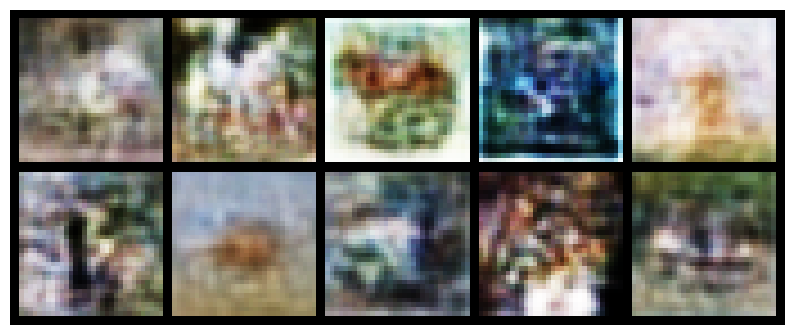

FID Score: 341.5219421386719 Inception Score: 1.0


In [ ]:
# Generate and Display Images
noise = torch.randn(10, z_dim).to(device)
labels = (
    torch.nn.functional.one_hot(torch.ones(10, dtype=torch.long), num_classes=n_classes)
    .float()
    .to(device)
)

# Load real images for FID comparison
real_images, _ = next(iter(dataloader))
real_images = ((real_images + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)

generated_images1 = gen1(noise, labels).view(-1, 3, 32, 32).cpu().detach()
grid = make_grid(generated_images1, nrow=5, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Convert generated images to uint8 format
generated_images_uint8 = (
    ((generated_images1 + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)
)

# Evaluate IS and FID
fid1 = FrechetInceptionDistance().to(device)
fid1.update(real_images, real=True)
fid1.update(generated_images_uint8, real=False)

is_score1 = InceptionScore().to(device)
is_score1.update(generated_images_uint8)

print(
    f"FID Score: {fid1.compute().item()}",
    f"Inception Score: {is_score1.compute()[0].item()}"
)

# Task 2: Implement and train a SNGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

In [ ]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 500
lr = 0.0002
z_dim = 100
img_dim = 32 * 32 * 3

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Spectral Normalization Generator
class Generator2(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 32 * 32 * 3),
            nn.Tanh(),
        )

    def forward(self, noise):
        return self.model(noise)

In [ ]:
# Spectral Normalization Discriminator
class Discriminator2(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(img_dim, 1024)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
# Initialize models
gen2 = Generator2(z_dim).to(device)
disc2 = Discriminator2(img_dim).to(device)
g_opt2 = optim.Adam(gen2.parameters(), lr=lr, betas=(0.5, 0.999))
d_opt2 = optim.Adam(disc2.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Training Loop
epoch_iter = tqdm(list(range(epochs)))

for epoch in epoch_iter:
    e_start = datetime.now()
    for real, _ in dataloader:
        real = real.view(real.size(0), -1).to(device)
        noise = torch.randn(real.size(0), z_dim).to(device)

        # Train Discriminator
        fake = gen2(noise).detach()
        d_loss = -(torch.mean(disc2(real)) - torch.mean(disc2(fake)))
        d_opt2.zero_grad()
        d_loss.backward()
        d_opt2.step()

        # Train Generator
        fake = gen2(noise)
        g_loss = -torch.mean(disc2(fake))
        g_opt2.zero_grad()
        g_loss.backward()
        g_opt2.step()

    e_end = datetime.now()

    epoch_iter.postfix = print_epoch(
        epoch_idx1=epoch + 1,
        epochs=epochs,
        critic_loss=d_loss.item(),
        generator_loss=g_loss.item(),
        time_taken_secs=(e_end - e_start).total_seconds(),
        loss1_prefix="D",
    )

[  0/500]  D_LOSS:  -3.5693  G_LOSS:  +7.1622  (17s)
[  1/500]  D_LOSS:  -1.1660  G_LOSS:  +6.2705  (15s)
[  2/500]  D_LOSS:  +0.9395  G_LOSS:  +6.1132  (15s)
[  3/500]  D_LOSS:  -4.8553  G_LOSS:  +6.4726  (15s)
[  4/500]  D_LOSS:  -5.1687  G_LOSS:  +4.3918  (17s)
[  5/500]  D_LOSS:  -0.0523  G_LOSS:  +2.9078  (15s)
[  6/500]  D_LOSS:  -3.5545  G_LOSS: +11.1862  (15s)
[  7/500]  D_LOSS:  -4.1019  G_LOSS:  +9.0614  (15s)
[  8/500]  D_LOSS:  -2.8816  G_LOSS:  +5.1344  (15s)
[  9/500]  D_LOSS:  -1.0430  G_LOSS:  +3.1264  (15s)
[ 10/500]  D_LOSS:  +2.4654  G_LOSS:  +5.9531  (15s)
[ 11/500]  D_LOSS:  -0.3115  G_LOSS:  +7.6142  (15s)
[ 12/500]  D_LOSS:  -2.3257  G_LOSS:  -0.9266  (15s)
[ 13/500]  D_LOSS:  +2.2567  G_LOSS:  +2.2088  (15s)
[ 14/500]  D_LOSS:  +0.0470  G_LOSS:  +0.1176  (15s)
[ 15/500]  D_LOSS:  +0.3034  G_LOSS:  +2.9906  (16s)
[ 16/500]  D_LOSS:  +1.2673  G_LOSS:  +3.1620  (15s)
[ 17/500]  D_LOSS:  -2.3795  G_LOSS:  +8.0454  (15s)
[ 18/500]  D_LOSS:  +0.5018  G_LOSS:  +6.9153 

In [ ]:
# This saves the generator, critic, and their optimizers to a specified directory.
# It ensures model checkpoints are stored for later use or resumption of training.
save_models({"gen": gen2, "gen_opt": g_opt2, "disc": disc2, "disc_opt": d_opt2,}, "task2/")

gen saved at /content/drive/MyDrive/mtechAssn/adl2/task2/gen.pt
gen_opt saved at /content/drive/MyDrive/mtechAssn/adl2/task2/gen_opt.pt
disc saved at /content/drive/MyDrive/mtechAssn/adl2/task2/disc.pt
disc_opt saved at /content/drive/MyDrive/mtechAssn/adl2/task2/disc_opt.pt


In [ ]:
saved_models = get_models("task2/")

if saved_models.get("gen", None):      gen2 = saved_models["gen"]
if saved_models.get("gen_opt", None):  g_opt2 = saved_models["gen_opt"]
if saved_models.get("disc", None):     disc2 = saved_models["disc"]
if saved_models.get("disc_opt", None): d_opt2 = saved_models["disc_opt"]

  0%|          | 0/4 [00:00<?, ?it/s]

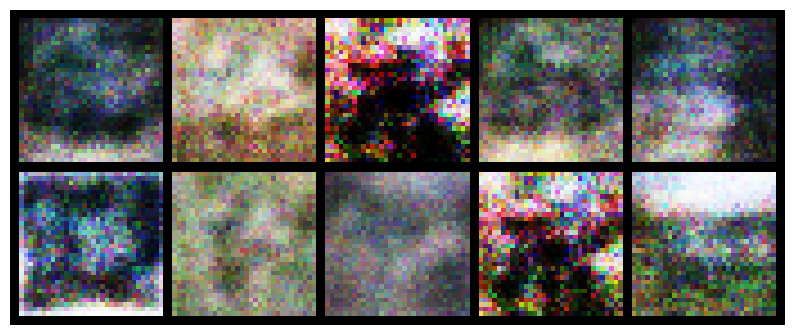

torch.Size([128, 3, 32, 32]) torch.Size([10, 3, 32, 32])


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FID Score: 402.21240234375, Inception Score: 1.0


In [ ]:
# Generate and Display Images
noise = torch.randn(10, z_dim).to(device)
labels = (
    torch.nn.functional.one_hot(torch.ones(10, dtype=torch.long), num_classes=n_classes)
    .float()
    .to(device)
)

# Load real images for FID comparison
real_images, _ = next(iter(dataloader))
real_images = ((real_images + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)

generated_images2 = gen2(noise).view(-1, 3, 32, 32).cpu().detach()
grid = make_grid(generated_images2, nrow=5, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Convert generated images to uint8 format
generated_images_uint8 = (
    ((generated_images2 + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)
)

print(real_images.shape, generated_images_uint8.shape)

# Evaluate IS and FID
fid2 = FrechetInceptionDistance().to(device)
is_score2 = InceptionScore().to(device)
fid2.update(real_images, real=True)
fid2.update(generated_images_uint8, real=False)
is_score2.update(generated_images_uint8)

print(
    f"FID Score: {fid2.compute().item()}, Inception Score: {is_score2.compute()[0].item()}"
)

# Task 3: Implement and train a variant of SAGAN without spectral normalization and TTUB  with CIFAR10 dataset. Generate 10 new images. Report IS and FID scores.

In [ ]:
# Hyperparameters
batch_size = 64
image_size = 32
z_dim = 128
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Self-Attention Module
class SelfAttention3(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention3, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, width, height = x.size()
        q = self.query(x).view(batch, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch, -1, width * height)
        attn = torch.bmm(q, k)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        v = self.value(x).view(batch, -1, width * height)
        attn_out = torch.bmm(v, attn.permute(0, 2, 1)).view(batch, C, width, height)
        return self.gamma * attn_out + x

In [ ]:
# Generator
class Generator3(nn.Module):
    def __init__(self, z_dim):
        super(Generator3, self).__init__()
        self.init_size = image_size // 4
        self.fc = nn.Linear(z_dim, 256 * self.init_size * self.init_size)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SelfAttention3(128),  # Self-Attention Layer
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z).view(z.shape[0], 256, self.init_size, self.init_size)
        return self.conv_blocks(out)

In [ ]:
# Discriminator (Without Spectral Normalization)
class Discriminator3(nn.Module):
    def __init__(self):
        super(Discriminator3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention3(128),  # Self-Attention Layer
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize models
gen3 = Generator3(z_dim).to(device)
disc3 = Discriminator3().to(device)

# Optimizers (Without TTUR, Using Adam for both G and D)
g_opt3 = optim.Adam(gen3.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_opt3 = optim.Adam(disc3.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Training Loop
epoch_iter = tqdm(list(range(epochs)))

for epoch in epoch_iter:
    e_start = datetime.now()

    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = gen3(z)
        d_loss = torch.mean(disc3(fake_images.detach())) - torch.mean(
            disc3(real_images)
        )
        d_opt3.zero_grad()
        d_loss.backward()
        d_opt3.step()

        # Train Generator
        g_loss = -torch.mean(disc3(fake_images))
        g_opt3.zero_grad()
        g_loss.backward()
        g_opt3.step()

    e_end = datetime.now()

    epoch_iter.postfix = print_epoch(
        epoch_idx1=epoch+1,
        epochs=epochs,
        critic_loss=d_loss.item(),
        generator_loss=g_loss.item(),
        time_taken_secs=(e_end - e_start).total_seconds(),
    )

  0%|          | 0/500 [00:00<?, ?it/s]

[  0/500]  C_LOSS:  +0.2627  G_LOSS: +14.3398  (24s)
[  1/500]  C_LOSS: -57.9965  G_LOSS: +125.6179  (22s)
[  2/500]  C_LOSS: -39.7883  G_LOSS: +169.0422  (21s)
[  3/500]  C_LOSS: -319.7415  G_LOSS: +781.0061  (21s)
[  4/500]  C_LOSS: -988.9827  G_LOSS: +1267.9901  (22s)
[  5/500]  C_LOSS: -1318.9550  G_LOSS: +1643.9780  (21s)
[  6/500]  C_LOSS: -1787.9327  G_LOSS: +1884.3741  (22s)
[  7/500]  C_LOSS: -226.2734  G_LOSS: +2676.2026  (22s)
[  8/500]  C_LOSS: -2747.3518  G_LOSS: +4800.0967  (21s)
[  9/500]  C_LOSS: -15.4907  G_LOSS: +4730.1807  (22s)
[ 10/500]  C_LOSS: -5452.4404  G_LOSS: +4983.6118  (22s)
[ 11/500]  C_LOSS: -1351.4950  G_LOSS: +4575.9536  (21s)
[ 12/500]  C_LOSS: -8020.3140  G_LOSS: +6413.6177  (22s)
[ 13/500]  C_LOSS: -6530.5889  G_LOSS: +9847.1035  (22s)
[ 14/500]  C_LOSS: -11325.0430  G_LOSS: +9800.1660  (21s)
[ 15/500]  C_LOSS: -16637.9414  G_LOSS: +13858.8184  (22s)
[ 16/500]  C_LOSS: -7141.6602  G_LOSS: +12643.2168  (22s)
[ 17/500]  C_LOSS: -20461.6445  G_LOSS: +14

In [ ]:
# This saves the generator, critic, and their optimizers to a specified directory.
# It ensures model checkpoints are stored for later use or resumption of training.
save_models({ "gen": gen3, "gen_opt": g_opt3, "disc": disc3, "disc_opt": d_opt3,}, "task3/")

gen saved at /content/drive/MyDrive/mtechAssn/adl2/task3/gen.pt
gen_opt saved at /content/drive/MyDrive/mtechAssn/adl2/task3/gen_opt.pt
disc saved at /content/drive/MyDrive/mtechAssn/adl2/task3/disc.pt
disc_opt saved at /content/drive/MyDrive/mtechAssn/adl2/task3/disc_opt.pt


In [ ]:
saved_models = get_models("task3/")

if saved_models.get("gen", None):      gen3 = saved_models["gen"]
if saved_models.get("gen_opt", None):  g_opt3 = saved_models["gen_opt"]
if saved_models.get("disc", None):     disc3 = saved_models["disc"]
if saved_models.get("disc_opt", None): d_opt3 = saved_models["disc_opt"]

  0%|          | 0/4 [00:00<?, ?it/s]

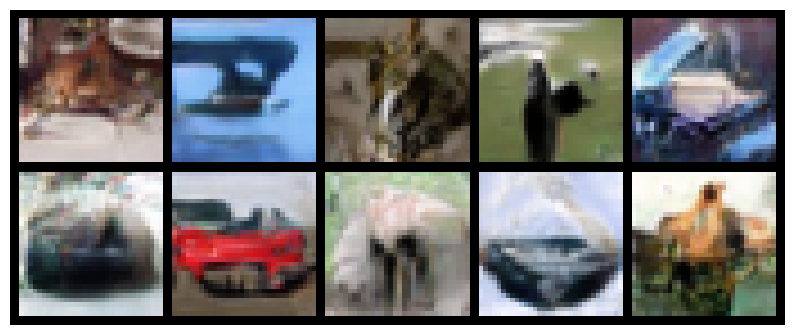

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FID Score: 320.3018, Inception Score: 1.0000


In [ ]:
# Generate & Display 10 Images
z = torch.randn(10, z_dim).to(device)
generated_images3 = gen3(z).cpu().detach()
grid = torchvision.utils.make_grid(generated_images3, nrow=5, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Evaluate FID and IS
fid3 = FrechetInceptionDistance().to(device)
is_score3 = InceptionScore().to(device)

generated_images_uint8 = (
    ((generated_images3 + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)
)
real_images, _ = next(iter(dataloader))
real_images = ((real_images + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)

fid3.update(real_images, real=True)
fid3.update(generated_images_uint8, real=False)
is_score3.update(generated_images_uint8)

print(
    f"FID Score: {fid3.compute().item():.4f}, Inception Score: {is_score3.compute()[0].item():.4f}"
)

# Task 4: Implement and train a complete SAGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

In [ ]:
# Hyperparameters
batch_size = 64
image_size = 32
z_dim = 128
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Self-Attention Module
class SelfAttention4(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention4, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, width, height = x.size()
        q = self.query(x).view(batch, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch, -1, width * height)
        attn = torch.bmm(q, k)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        v = self.value(x).view(batch, -1, width * height)
        attn_out = torch.bmm(v, attn.permute(0, 2, 1)).view(batch, C, width, height)
        return self.gamma * attn_out + x


In [ ]:
# Spectral Normalization
def spectral_norm4(module):
    return nn.utils.spectral_norm(module)

# Generator
class Generator4(nn.Module):
    def __init__(self, z_dim):
        super(Generator4, self).__init__()
        self.init_size = image_size // 4
        self.fc = spectral_norm4(nn.Linear(z_dim, 256 * self.init_size * self.init_size))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            spectral_norm4(nn.Conv2d(256, 128, 3, stride=1, padding=1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SelfAttention4(128),
            nn.Upsample(scale_factor=2),
            spectral_norm4(nn.Conv2d(128, 64, 3, stride=1, padding=1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            spectral_norm4(nn.Conv2d(64, 3, 3, stride=1, padding=1)),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z).view(z.shape[0], 256, self.init_size, self.init_size)
        return self.conv_blocks(out)

In [ ]:
# Discriminator with Spectral Normalization
class Discriminator4(nn.Module):
    def __init__(self):
        super(Discriminator4, self).__init__()
        self.model = nn.Sequential(
            spectral_norm4(nn.Conv2d(3, 64, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm4(nn.Conv2d(64, 128, 3, stride=2, padding=1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention4(128),
            spectral_norm4(nn.Conv2d(128, 256, 3, stride=2, padding=1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            spectral_norm4(nn.Linear(256 * 4 * 4, 1)),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize models
gen4 = Generator4(z_dim).to(device)
disc4 = Discriminator4().to(device)

# Optimizers (TTUR: Different Learning Rates)
g_opt4 = optim.Adam(gen4.parameters(), lr=0.0001, betas=(0.0, 0.9))
d_opt4 = optim.Adam(disc4.parameters(), lr=0.0004, betas=(0.0, 0.9))

In [ ]:
# Training Loop
epoch_iter = tqdm(list(range(epochs)))

for epoch in epoch_iter:
    e_start = datetime.now()

    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = gen4(z)
        d_loss = torch.mean(disc4(fake_images.detach())) - torch.mean(
            disc4(real_images)
        )
        d_opt4.zero_grad()
        d_loss.backward()
        d_opt4.step()

        # Train Generator
        g_loss = -torch.mean(disc4(fake_images))
        g_opt4.zero_grad()
        g_loss.backward()
        g_opt4.step()

    e_end = datetime.now()

    epoch_iter.postfix = print_epoch(
        epoch_idx1=epoch+1,
        epochs=epochs,
        critic_loss=d_loss.item(),
        generator_loss=g_loss.item(),
        time_taken_secs=(e_end - e_start).total_seconds(),
    )


  0%|          | 0/500 [00:00<?, ?it/s]

[  1/500]  C_LOSS: -42.3099  G_LOSS: +48.7160  (29s)
[  2/500]  C_LOSS: -34.3155  G_LOSS: +34.5451  (29s)
[  3/500]  C_LOSS: -65.9058  G_LOSS: +62.4395  (29s)
[  4/500]  C_LOSS: -104.3845  G_LOSS: +38.9089  (29s)
[  5/500]  C_LOSS: -79.8452  G_LOSS: +76.2190  (28s)
[  6/500]  C_LOSS: -100.8749  G_LOSS: +52.7811  (28s)
[  7/500]  C_LOSS: -154.2054  G_LOSS: +126.4523  (29s)
[  8/500]  C_LOSS: -143.9021  G_LOSS: +110.8590  (28s)
[  9/500]  C_LOSS: -90.7025  G_LOSS: +151.0862  (28s)
[ 10/500]  C_LOSS: -107.8586  G_LOSS: +118.4548  (28s)
[ 11/500]  C_LOSS: -79.5114  G_LOSS: +188.0582  (28s)
[ 12/500]  C_LOSS: -193.5470  G_LOSS: +212.6293  (29s)
[ 13/500]  C_LOSS: -162.7025  G_LOSS: +103.0019  (28s)
[ 14/500]  C_LOSS: -135.1176  G_LOSS: +224.4739  (28s)
[ 15/500]  C_LOSS: -175.9995  G_LOSS: +234.8956  (28s)
[ 16/500]  C_LOSS: -213.4380  G_LOSS: +285.4509  (29s)
[ 17/500]  C_LOSS: -260.5036  G_LOSS: +292.0108  (29s)
[ 18/500]  C_LOSS: -121.0920  G_LOSS: +128.1721  (28s)
[ 19/500]  C_LOSS: -29

In [ ]:
# This saves the generator, critic, and their optimizers to a specified directory.
# It ensures model checkpoints are stored for later use or resumption of training.
save_models({ "gen": gen4, "gen_opt": g_opt4, "disc": disc4, "disc_opt": d_opt4,}, "task4/")

gen saved at /content/drive/MyDrive/mtechAssn/adl2/task4/gen.pt
gen_opt saved at /content/drive/MyDrive/mtechAssn/adl2/task4/gen_opt.pt
disc saved at /content/drive/MyDrive/mtechAssn/adl2/task4/disc.pt
disc_opt saved at /content/drive/MyDrive/mtechAssn/adl2/task4/disc_opt.pt


In [ ]:
saved_models = get_models("task4/")

if saved_models.get("gen", None):      gen4 = saved_models["gen"]
if saved_models.get("gen_opt", None):  g_opt4 = saved_models["gen_opt"]
if saved_models.get("disc", None):     disc4 = saved_models["disc"]
if saved_models.get("disc_opt", None): d_opt4 = saved_models["disc_opt"]

  0%|          | 0/4 [00:00<?, ?it/s]

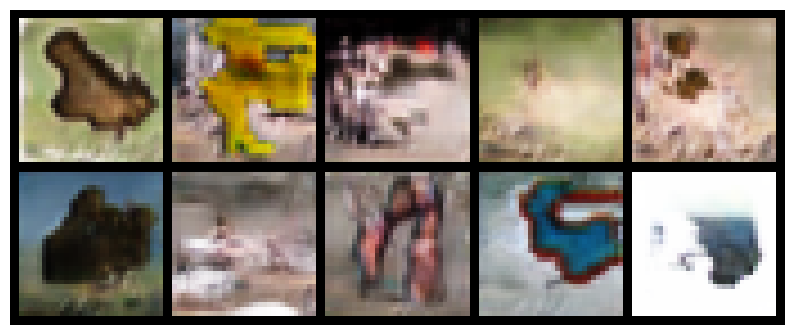

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FID Score: 324.2639, Inception Score: 1.0000


In [ ]:
# Generate & Display 10 Images
z = torch.randn(10, z_dim).to(device)
generated_images4 = gen4(z).cpu().detach()
grid = torchvision.utils.make_grid(generated_images4, nrow=5, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Evaluate FID and IS
fid4 = FrechetInceptionDistance().to(device)
is_score4 = InceptionScore().to(device)

generated_images_uint8 = (
    ((generated_images4 + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)
)
real_images, _ = next(iter(dataloader))
real_images = ((real_images + 1) * 127.5).clamp(0, 255).to(torch.uint8).to(device)

fid4.update(real_images, real=True)
fid4.update(generated_images_uint8, real=False)
is_score4.update(generated_images_uint8)

print(
    f"FID Score: {fid4.compute().item():.4f}, Inception Score: {is_score4.compute()[0].item():.4f}"
)

# Task 5: Summarize your observations.

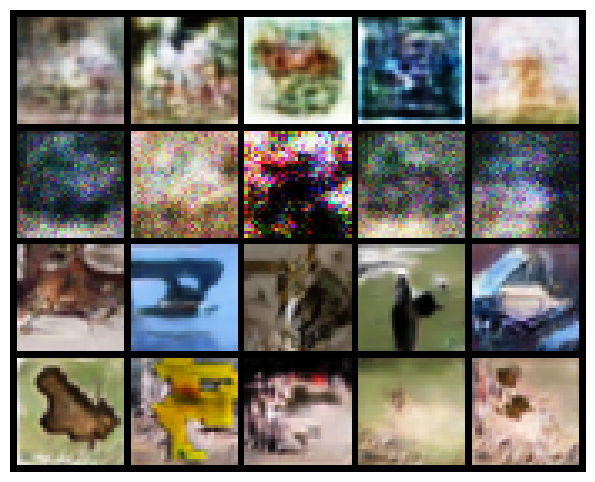

In [ ]:
# Sample model names — adjust to match your actual models
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]

imgs = torch.vstack([eval(f"generated_images{idx}")[:5] for idx in range(1, 5) ])
grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True)
plt.figure(figsize=(10, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [ ]:
df = pd.DataFrame([
    {
        "Model_Idx": idx,
        "Total_Params": sum(p.numel() for p in eval(f"gen{idx}").parameters()),
        "Trainable_Params": sum(p.numel() for p in eval(f"gen{idx}").parameters() if p.requires_grad),
        "FID Score": eval(f"fid{idx}").compute().item(),
        "Inception Score": eval(f"is_score{idx}").compute()[0].item()
    } for idx in range(1, 5)
])
df

,Model_Idx,Total_Params,Trainable_Params,FID Score,Inception Score
0,1,3837696,3837696,341.521942,1.0
1,2,3835136,3835136,402.212402,1.0
2,3,2505636,2505636,320.301819,1.0
3,4,2505636,2505636,324.263947,1.0


## Observations:

1. Even though Mode 3 and 4 are optimal, the FID score of Model 3 has the lowest value (320.30), generating most realistic images among all.

1. Inception Score wise, all models have pretty good score which is mostly 1.0, so there's no advantage in diversity or class-related quality for any model.

## Conclusion:

1. Model 3 seems to be the best choice in the current context with the training with the lowest FID score.

